# Electron Hybrid Code
Dipole Field $B_{z}=B_{0}(1+\xi z^2)$.
Homogeneous Dirichlet boundary conditions for $E_x, E_y, B_x, B_y, j_x, j_y$ with damping at ends of interval.

In [12]:
import numpy as np
import time
from copy import deepcopy
from scipy.linalg import block_diag
import Utilitis_HybridCode as utils



# ... start the simulation from the beginning (0) or continue (1)  
restart = 0    


# ... directory for saving simulation data
title = 'Results/02_DipoleField/test.txt' 


# ... save only the data of every saving_step-th time step (reduces size of data file)
saving_step = 2                    



# ... physical parameters
eps0 = 1.0                         # ... vacuum permittivity
mu0 = 1.0                          # ... vacuum permeability
c = 1.0                            # ... speed of light
qe = -1.0                          # ... electron charge
me = 1.0                           # ... electron mass
B0z = 1.0                          # ... minimum of background magnetic field in z-direction at z = Lz/2
wce = qe*B0z/me                    # ... electron cyclotron frequency
wpe = 5*np.abs(wce)                # ... cold electron plasma frequency
nuh = 6e-3                         # ... ratio of cold/hot electron densities (nh/nc)
nh = nuh*wpe**2                    # ... hot electron density
wpar = 0.2*c                       # ... parallel thermal velocity of energetic particles
wperp = 0.53*c                     # ... perpendicular thermal velocity of energetic particles

xi = 8.62e-5                       # ... inhomogeneity factor of background magnetic field

bcs_p = 2                          # ... particle boundary conditions (1: periodic, 2: reflecting)
bcs_f = 2                          # ... boundary conditions for fields (1: periodic, 2: hom. Dirichlet)
bcs_d = 1                          # ... boundary condition for damping (1: on, 0: off)
bcs_g = 1                          # ... boundary condition for distribution function (1: field line dependence, 0: uniform)
# ...




# ... parameters for initial conditions
k = 2                              # ... wavenumber of initial wave fields
ini = 6                            # ... initial conditions for wave fields
amp = 1e-4                         # ... amplitude of initial wave fields
eps = 0.0                          # ... amplitude of spatial pertubation of distribution function 
# ...



# ... numerical parameters
Lz = 327.7                         # ... total length of z-domain
Nel = 400                          # ... number of elements z-direction
T = 3000                           # ... simulation time
dt = 0.1                           # ... time step
p = 3                              # ... degree of B-spline basis
Lv = 2                             # ... length of v-domain in each direction (vx,vy,vz)
Nv = 76                            # ... number of cells in each v-direction (vx,vy,vz)
Np = np.int(8e5)                   # ... number of energetic simulation particles 

Ld = 0.1*Lz                        # ... length of damping region at each end 
# ...



# ... create parameter list
if bcs_f == 1:
    pa = np.zeros(1*Nel + 1)
elif bcs_f == 2:
    pa = np.zeros(1*(Nel + p - 2) + 1)

pa[0]  = eps0
pa[1]  = mu0
pa[2]  = c
pa[3]  = qe 
pa[4]  = me 
pa[5]  = B0z 
pa[6]  = wce 
pa[7]  = wpe 
pa[8]  = nuh 
pa[9]  = nh 
pa[10] = wpar 
pa[11] = wperp 
pa[12] = k 
pa[13] = ini 
pa[14] = amp 
pa[15] = eps 
pa[16] = Lz 
pa[17] = Nel 
pa[18] = T 
pa[19] = dt 
pa[20] = p 
pa[21] = Lv 
pa[22] = Nv 
pa[23] = Np 
pa[24] = xi
pa[25] = Ld

pa[26] = bcs_p
pa[27] = bcs_f
pa[28] = bcs_d
pa[29] = bcs_g
pa[30] = saving_step
# ...



# ... discretization parameters and diagnostic values (e.g. energies)
dz = Lz/Nel
el_b = np.linspace(0, Lz, Nel + 1)


dv = Lv/Nv
vj = np.linspace(-Lv/2, Lv/2, Nv + 1)

en_B = np.array([])
# ...






# ... system matrices for fluid electrons and electromagnetic fields and definition of background magnetic field B_background B0
A10 = np.array([0, 0, 0, c**2, 0, 0])
A11 = np.array([0, 0, -c**2, 0, 0, 0])
A12 = np.array([0, -1, 0, 0, 0, 0])
A13 = np.array([1, 0, 0, 0, 0, 0])
A14 = np.array([0, 0, 0, 0, 0, 0])
A15 = np.array([0, 0, 0, 0, 0, 0])
A1 = np.array([A10, A11, A12, A13, A14, A15])

A20 = np.array([0, 0, 0, 0, mu0*c**2, 0])
A21 = np.array([0, 0, 0, 0, 0, mu0*c**2])
A22 = np.array([0, 0, 0, 0, 0, 0])
A23 = np.array([0, 0, 0, 0, 0, 0])
A24 = np.array([-eps0*wpe**2, 0, 0, 0, 0, -wce])
A25 = np.array([0, -eps0*wpe**2, 0, 0, wce, 0])
A2 = np.array([A20, A21, A22, A23, A24, A25])

s = int(np.sqrt(A1.size))

def B_background_z(z):
    return B0z*(1 + xi*(z - Lz/2)**2)

def B_background(x,y,z):
    
    Bx = -x*(z - Lz/2)*B0z*xi
    By = -y*(z - Lz/2)*B0z*xi
    Bz = B0z*(1 + xi*(z - Lz/2)**2)
    
    return np.transpose(np.array([Bx, By, Bz]))
# ...




# ... time integration 
def update(uj, particles, Ep, Bp, dt):
    
    
    # ... save old positions
    zold = deepcopy(particles[:, 0])
    # ...
    
    
    # ... update particle velocities from n-1/2 to n+1/2 with fields at time n and positions from n to n+1 with velocities at n+1/2
    znew, vnew = utils.borisPush(particles, dt, Bp, Ep, qe, me, Lz, bcs_p)
    # ...
    
    
    # ... update weights with control variate
    wnew = w0 - Maxwell(vnew[:, 0], vnew[:, 1], vnew[:, 2])/g0
    # ...
    
    
    # ... compute hot electron current densities
    jhnew = utils.hotCurrent(vnew[:, 0:2], 1/2*(znew + zold), wnew, el_b, bsp, qe, c, bcs = bcs_f)
    # ...
     
    
    # ... assemble right-hand side of weak formulation
    Fh[0::s] = -c**2*mu0*jhnew[0::2]
    Fh[1::s] = -c**2*mu0*jhnew[1::2]
    # ...
    
    
    # ... time integration of E,B,jc from n to n+1 with Crank-Nicolson method (use hot current density at n+1/2) 
    ujnew = np.dot(LHSinv, np.dot(RHS, uj) + dt*Fh)
    
    if bcs_d == 1:
        ujnew = np.dot(DAMPblock, ujnew)
    # ...
    
    
    # ... compute fields at particle positions with new fields (wave + background)
    Epnew_xy, Bpnew_xy = utils.fieldInterpolation(znew, el_b, bsp, ujnew, bcs_f)
    
    Bpnew_z = B_background_z(znew)
    rho = -me/qe*np.cross(vnew, np.array([0, 0, 1]))/Bpnew_z[:, None]
    
    Bpnew_xy += B_background(rho[:, 0], rho[:, 1], znew)[:, 0:2]
    # ...
    
    return znew, vnew, wnew, jhnew, ujnew, Epnew_xy, Bpnew_xy, Bpnew_z
# ...






if restart == 0:

    
    # ... initial energetic particle distribution function (perturbed anisotropic Maxwellian)
    def fh0(z, vx, vy, vz):
        
        xiB = 1 - B0z/B_background_z(z)
        xiz = 1 + (wperp**2/wpar**2 - 1)*xiB*bcs_g
        
        return (1 + eps*np.cos(k*z))*nh/((2*np.pi)**(3/2)*wpar*wperp**2)*np.exp(-vz**2/(2*wpar**2) - xiz*(vx**2 + vy**2)/(2*wperp**2))
    # ...


    # ... Maxwellian for control variate
    def Maxwell(vx, vy, vz):
        return nh/((2*np.pi)**(3/2)*wpar*wperp**2)*np.exp(-vz**2/(2*wpar**2) - (vx**2 + vy**2)/(2*wperp**2))
    # ...


    # ... sampling distribution for initial markers
    def g_sampling(vx, vy, vz):
        return 1/((2*np.pi)**(3/2)*wpar*wperp**2)*np.exp(-vz**2/(2*wpar**2) - (vx**2 + vy**2)/(2*wperp**2))*1/Lz
    # ...

    
    
    # ... masking function to damp wave fields near boundaries (and derivatives)
    def damp(z):
        
        if z <= Ld:
            return np.sin(np.pi*z/(2*Ld))
        elif z >= Lz - Ld:
            return np.sin(np.pi*(Lz - z)/(2*Ld))
        else:
            return 1.0
    # ...
    


    # ... create B-spline basis and quadrature grid
    bsp, Nbase, quad_points, weights = utils.createBasis(Lz, Nel, p, bcs_f)
    # ...
    
    
    if bcs_d == 1:
        # ... assemble damping matrix
        timea = time.time()

        DAMP = utils.dampingAssembly(bsp, damp, 2)

        timeb = time.time()
        print('time for damping matrix assembly: ' + str(timeb - timea))
        # ...


        # ... assemble block damping matrix
        timea = time.time()
        DAMPblock = np.zeros((s*(Nbase - 2), s*(Nbase - 2)))

        for i in range(0, s):
            DAMPblock[i::s, i::s] = DAMP

        timeb = time.time()
        print('time for block damping matrix assembly: ' + str(timeb - timea))
        # ...



    # ... matrices for linear system
    if bcs_f == 1:
        Nb = Nbase - p                # ... number of degrees of freedom (= number of eq.)
    elif bcs_f == 2:
        Nb = Nbase - 2                # ... number of degrees of freedom (= number of eq.)

    uj = np.zeros(s*Nb)               # ... coefficients for Galerkin approximation
    Fh = np.zeros(s*Nb)               # ... RHS of matrix system

    Mblock = np.zeros((s*Nb, s*Nb))   # ... block mass matrix    
    Cblock = np.zeros((s*Nb, s*Nb))   # ... block convection matrix
    Dblock = np.zeros((s*Nb, s*Nb))   # ... block background field matrix

    u0 = np.zeros((Nb, s))            # ... initial coefficients obtained by L2-projection

    A1block = block_diag(*([A1]*Nb))  # ... block system matrix A1
    A2block = block_diag(*([A2]*Nb))  # ... block system matrix A2
    # ...





    # ... assemble mass, convection and background field matrices
    timea = time.time()

    M, C, D = utils.matrixAssembly(bsp, weights, quad_points, B_background_z, bcs_f)

    timeb = time.time()
    print('time for matrix assembly: ' + str(timeb - timea))
    # ...




    # ... assemble initial coefficient vector
    if bcs_f == 1:
        
        timea = time.time()

        for qu in range (0, s):

            def initial(z):
                return utils.IC(z, ini, amp, k, omega = 0)[qu]

            u0[:,qu] = utils.L2proj(bsp, Lz, quad_points, weights, M, initial, bcs_f)

        uj = np.reshape(u0, s*Nb)
        timeb = time.time()
        print('time for intial vector assembly: ' + str(timeb - timea))
        
    elif bcs_f == 2:
        
        timea = time.time()

        for qu in range (0 ,s):

            def initial(z):
                return utils.IC(z, ini, amp, k, omega = 0)[qu]

            u0[:,qu] = utils.L2proj(bsp, Lz, quad_points, weights, M,initial, bcs_f)[1:Nbase - 1]

        uj = np.reshape(u0, s*Nb)
        
        timeb = time.time()
        print('time for intial vector assembly: ' + str(timeb - timea))
    # ...


    


    # ... construct block mass, convection and field matrices
    timea = time.time()
    
    if bcs_f == 1:
        
        for i in range(0, s):
            Mblock[i::s, i::s] = M
            Cblock[i::s, i::s] = C
            
            for j in range(s):
                
                if i == 4 and j == 5:
                    Dblock[i::s, j::s] = A2[i, j]*D
                elif i == 5 and j == 4:
                    Dblock[i::s, j::s] = A2[i, j]*D
                else:
                    Dblock[i::s, j::s] = A2[i, j]*M
            
                
    elif bcs_f == 2:
        
        for i in range(s):
            Mblock[i::s, i::s] = M[1:Nbase - 1, 1:Nbase - 1]
            Cblock[i::s, i::s] = C[1:Nbase - 1, 1:Nbase - 1]
                
            for j in range(s):
                    
                if i == 4 and j == 5:
                    Dblock[i::s, j::s] = A2[i, j]*D[1:Nbase - 1, 1:Nbase - 1]
                        
                elif i == 5 and j == 4:
                    Dblock[i::s, j::s] = A2[i, j]*D[1:Nbase - 1, 1:Nbase - 1]
                        
                else:
                    Dblock[i::s, j::s] = A2[i, j]*M[1:Nbase - 1, 1:Nbase - 1]
         
                
    timeb = time.time()
    print('time for block matrix assembly: ' + str(timeb - timea))
    # ...





    # ... create particles (z, vx, vy, vz, wk) and sample positions and velocities according to sampling distribution
    particles = np.zeros((Np, 5))
    particles[:, 0] = np.random.rand(Np)*Lz
    particles[:, 1] = np.random.randn(Np)*wperp
    particles[:, 2] = np.random.randn(Np)*wperp
    particles[:, 3] = np.random.randn(Np)*wpar
    # ...




    # ... parameters for control variate
    g0 = g_sampling(particles[:, 1], particles[:, 2], particles[:, 3])
    w0 = fh0(particles[:, 0], particles[:, 1], particles[:, 2], particles[:, 3])/g_sampling(particles[:, 1], particles[:, 2], particles[:, 3])
    # ...




    # ... initial fields at particle positions
    Ep = np.zeros((Np, 3))
    Bp = np.zeros((Np, 3))
    
    timea = time.time()
    
    Ep[:, 0:2], Bp[:, 0:2] = utils.fieldInterpolation(particles[:, 0], el_b, bsp, uj, bcs_f)
    
    
    Bp[:, 2] = B_background_z(particles[:, 0])
    rho = -me/qe*np.cross(particles[:, 1:4], np.array([0, 0, 1]))/Bp[:, 2][:, None]
    
    Bp[:, 0:2] += B_background(rho[:, 0], rho[:, 1], particles[:, 0])[:, 0:2]

    timeb = time.time()
    print('time for initial field interpolation: ' + str(timeb - timea))
    # ...




    # ... initialize velocities by pushing back by -dt/2 and compute weights
    timea = time.time()

    particles[:, 1:4] = utils.borisPush(particles, -dt/2, Bp, Ep, qe, me, Lz, bcs_p)[1]
    particles[:, 4] = w0 - Maxwell(particles[:, 1], particles[:, 2], particles[:, 3])/g0

    timeb = time.time()
    print('time for initial particle push: ' + str(timeb - timea))
    #
    




    # ... compute matrices for field update
    timea = time.time()

    LHS = Mblock + 1/2*dt*np.dot(Cblock,A1block) + 1/2*dt*Dblock
    RHS = Mblock - 1/2*dt*np.dot(Cblock,A1block) - 1/2*dt*Dblock
    LHSinv = np.linalg.inv(LHS)

    timeb = time.time()
    print('time for update matrix computation: ' + str(timeb - timea))
    # ...




    
    # ... create data file and save parameters (first row) and initial fields (second row)
    file = open(title, 'ab')


    np.savetxt(file, np.reshape(pa, (1, 1*Nb + 1)), fmt = '%1.5e')
    
    en_B  = np.append(en_B, eps0/(2*mu0)*(np.dot(np.array([0] + list(uj[2::s]) + [0]), np.dot(M, np.array([0] + list(uj[2::s]) + [0]))) + np.dot(np.array([0] + list(uj[3::s]) + [0]), np.dot(M, np.array([0] + list(uj[3::s]) + [0])))))

    data = np.append(uj[2::s], en_B)
                      
    np.savetxt(file, np.reshape(data, (1, 1*Nb + 1)), fmt = '%1.5e')
    # ...


    # ... time loop
    print('start time integration!')
    time_step = 0

    while True:

        try:
            if time_step%50 == 0:
                print('time steps finished: ' + str(time_step))

            particles[:, 0], particles[:, 1:4], particles[:, 4], jh, uj, Ep[:, 0:2], Bp[:, 0:2], Bp[:, 2] = update(uj, particles, Ep, Bp, dt)

            if time_step%saving_step == 0:
                      
                # ... add data to file
                en_B  = np.append(en_B, eps0/(2*mu0)*(np.dot(np.array([0] + list(uj[2::s]) + [0]), np.dot(M, np.array([0] + list(uj[2::s]) + [0]))) + np.dot(np.array([0] + list(uj[3::s]) + [0]), np.dot(M, np.array([0] + list(uj[3::s]) + [0])))))
                
                data = np.append(uj[2::s], en_B[-1])
                np.savetxt(file, np.reshape(data, (1, 1*Nb + 1)), fmt = '%1.4e')
                # ...

                
            time_step += 1
        except KeyboardInterrupt:
            print('Pausing...  (Hit ENTER to continue, type quit to exit.)')
            try:
                file.close()
                        
                response = input()
                if response == 'quit':
                    break
                print('Resuming...')
                
                file = open(title, 'ab')
            except KeyboardInterrupt:
                print('Resuming...')
                continue
    # ...
    

    file.close()
    
  
    

    
    
    
    
if restart == 1:
    
    # ... open data file that hasn't been finished yet
    file = open(title, 'ab')
    # ...


    # ... time loop
    print('total number of time steps: ' + str(Nt))

    for i in range(n, Nt):

        if i%50 == 0:
            print('time steps finished: ' + str(i))

        particles[:, 0], particles[:, 1:4], particles[:, 4], jh, uj, Ep[:, 0:2], Bp[:, 0:2], Bp[:, 2] = update(uj, particles, Ep, Bp, dt)

        if i%10 == 0:
            # ... add data to file
            data = np.append(uj, jh)
            data = np.append(data, tn[i + 1])
            np.savetxt(file, np.reshape(data, (1, 8*Nb + 1)), fmt = '%1.4e')
            # ...
    # ...


    file.close()

time for damping matrix assembly: 3.8589794635772705
time for block damping matrix assembly: 0.02144145965576172
time for matrix assembly: 3.9517621994018555
time for intial vector assembly: 5.579784870147705
time for block matrix assembly: 0.10551929473876953
time for initial field interpolation: 1.245110034942627
time for initial particle push: 0.19760751724243164
time for update matrix computation: 3.2256221771240234
start time integration!
time steps finished: 0
Pausing...  (Hit ENTER to continue, type quit to exit.)
exit
Resuming...
Pausing...  (Hit ENTER to continue, type quit to exit.)
quit


In [9]:
# plot distribution function
Lv = 8
Nbin = 256
fdens = np.zeros((Nbin, Nbin))

dz_bin = Lz/Nbin
dv_bin = Lv/Nbin
z_bin = np.linspace(0, Lz, Nbin + 1)
z_bin = np.delete(z_bin, -1) + dz_bin/2
v_bin = np.linspace(-Lv/2, Lv/2, Nbin + 1)
v_bin = np.delete(v_bin, -1) + dv_bin/2

Zedges = np.linspace(0, Lz, Nbin + 1)
Vedges = np.linspace(-Lv/2, Lv/2, Nbin + 1)
ZZ, VV = np.meshgrid(z_bin, v_bin)
binVol = dz_bin*dv_bin


# ... update distribution function
Zbin = np.digitize(particles[:, 0], Zedges) - 1
Vbin = np.digitize(particles[:, 3], Vedges) - 1

for i in range(0, Nbin):
    fdens[:, i] = np.bincount(Vbin[np.where(Zbin == i)[0]], particles[np.where(Zbin == i)[0], 4], Nbin)

fdens = fdens/(Np*binVol)
# ...

Text(0,0.5,'$v_\\parallel$')

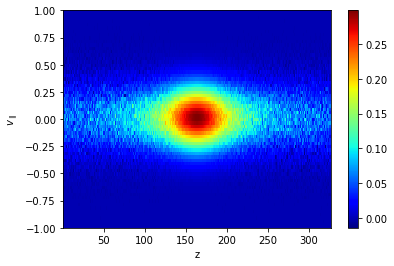

In [10]:
import matplotlib.pyplot as plt
plt.pcolor(ZZ, VV, fdens + Maxwell(0, 0, VV)*2*np.pi*wperp**2, cmap = 'jet')
plt.colorbar()
plt.ylim((-1,1))
plt.xlabel('z')
plt.ylabel('$v_\parallel$')